# This Pipeline creates an activity detection pipeline to classify videos using the UCF101 subset by Michael Wu

The pipline will have these main steps:

1. view the dataset (N/A for now)
2. Load in the dataset/create dataloader
3. Use pre-trained model for higher metrics
4. Train the model
5. Access performance

This provides a baseline for activity detection. Segmentation is still being done

In [ ]:
# Load in the data
import kagglehub

# Download latest version
path = kagglehub.dataset_download("aisuko/ucf101-subset")

print("Path to dataset files:", path)

100%|██████████| 157M/157M [00:00<00:00, 179MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/aisuko/ucf101-subset/versions/1


In [ ]:
cp -r /root/.cache/kagglehub/datasets/aisuko/ucf101-subset/versions/1 /content/dataset/

In [ ]:
!pip install -U av
import os
os.kill(os.getpid(), 9)


In [1]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision.io import read_video
import matplotlib.pyplot as plt
from tqdm import tqdm
import os
import numpy as np
import pandas as pd

# Create custom Pandas DF

In [2]:
import os

def create_df(dir_path):
    vid_path = []
    label = []

    class_names = os.listdir(dir_path)
    for class_name in class_names:
        class_path = os.path.join(dir_path, class_name)
        if not os.path.isdir(class_path):
            continue  # skip non-directory files
        for video in os.listdir(class_path):
            video_path = os.path.join(class_path, video)
            vid_path.append(video_path)
            label.append(class_name)

    return vid_path, label

train_imgs, train_labels = create_df("/content/dataset/UCF101_subset/train")
val_imgs, val_labels = create_df("/content/dataset/UCF101_subset/val")
test_imgs, test_labels = create_df("/content/dataset/UCF101_subset/test")

In [3]:
# Create custom dataframes
train_df = pd.DataFrame({"path": train_imgs, "label": train_labels})
val_df = pd.DataFrame({"path": val_imgs, "label": val_labels})
test_df = pd.DataFrame({"path": test_imgs, "label": test_labels})
test_df.head()


,path,label
0,/content/dataset/UCF101_subset/test/BabyCrawli...,BabyCrawling
1,/content/dataset/UCF101_subset/test/BabyCrawli...,BabyCrawling
2,/content/dataset/UCF101_subset/test/BabyCrawli...,BabyCrawling
3,/content/dataset/UCF101_subset/test/BabyCrawli...,BabyCrawling
4,/content/dataset/UCF101_subset/test/BabyCrawli...,BabyCrawling


# Create Custom Video Dataset

In [4]:
# Create a custom video dataset
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
class ActivityVideoDataset(Dataset):
  def __init__(self, dataframe, transform=None):
    self.dataframe = dataframe
    self.transform = transform
    self.label_encoder = label_encoder

    self.labels = torch.tensor(self.label_encoder.fit_transform(self.dataframe["label"])).long()

  def __len__(self):
    return self.dataframe.shape[0]


  def __getitem__(self, idx):
    path = self.dataframe["path"][idx]
    label = self.labels[idx]
    video, _, _ = read_video(path, pts_unit="sec")
    video = video.permute(0, 3, 1, 2)  # (T, C, H, W)


    # Sample n frames
    frame_num = 8
    frames = video[::max(1, len(video)//frame_num)][:frame_num]
    if self.transform:
        frames = torch.stack([self.transform(f) for f in frames])  # Each f is (C, H, W)

    frames = frames.permute(1, 0, 2, 3)  # (T, C, H, W) -> (C, T, H, W)


    return frames, label




In [5]:
from torchvision import transforms

train_transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ConvertImageDtype(torch.float32),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
])

transform =  transforms.Compose([
    transforms.Resize((128, 128)),
    #transforms.RandomHorizontalFlip(),
    #transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ConvertImageDtype(torch.float32),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
])



train_dataset = ActivityVideoDataset(train_df, train_transform)
val_dataset = ActivityVideoDataset(val_df, transform)
test_dataset = ActivityVideoDataset(test_df, transform)

# Dataloader

In [6]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=True)

imgs, label = next(iter(train_loader))
print(imgs.shape, label.shape)

torch.Size([32, 3, 8, 128, 128]) torch.Size([32])


# Custom MODEL!

In [31]:
import torchvision.models.video as models
from torchinfo import summary

import torch.nn as nn

class ModifiedR2Plus1D(nn.Module):
    def __init__(self, base_model, num_classes, dropout_p=0.5):
        super().__init__()
        self.features = nn.Sequential(*list(base_model.children())[:-1])  # All layers except last FC
        self.dropout = nn.Dropout(dropout_p)
        self.fc = nn.Linear(base_model.fc.in_features, num_classes)

    def forward(self, x):
        x = self.features(x)   # (batch, feat_dim, 1, 1, 1)
        x = x.flatten(1)       # Flatten to (batch, feat_dim)
        x = self.dropout(x)
        x = self.fc(x)
        return x

model = models.r2plus1d_18(pretrained=True)
model = ModifiedR2Plus1D(model, len(train_df["label"].unique()))

summary(model, input_size=(32, 3, 8, 128, 128))

Layer (type:depth-idx)                             Output Shape              Param #
ModifiedR2Plus1D                                   [32, 10]                  --
├─Sequential: 1-1                                  [32, 512, 1, 1, 1]        --
│    └─R2Plus1dStem: 2-1                           [32, 64, 8, 64, 64]       --
│    │    └─Conv3d: 3-1                            [32, 45, 8, 64, 64]       6,615
│    │    └─BatchNorm3d: 3-2                       [32, 45, 8, 64, 64]       90
│    │    └─ReLU: 3-3                              [32, 45, 8, 64, 64]       --
│    │    └─Conv3d: 3-4                            [32, 64, 8, 64, 64]       8,640
│    │    └─BatchNorm3d: 3-5                       [32, 64, 8, 64, 64]       128
│    │    └─ReLU: 3-6                              [32, 64, 8, 64, 64]       --
│    └─Sequential: 2-2                             [32, 64, 8, 64, 64]       --
│    │    └─BasicBlock: 3-7                        [32, 64, 8, 64, 64]       222,016
│    │    └─BasicBlock:

# Train the model :)

In [8]:


optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)

loss_fn = nn.CrossEntropyLoss()

def training_loop(n_epochs, model, optimizer, loss_fn, train_loader, val_loader, patience=8):
    train_loss_graph = []
    train_acc_graph = []
    val_loss_graph = []
    val_acc_graph = []

    best_val_loss = float('inf')
    trigger_times = 0

    for epoch in range(1, n_epochs + 1):
        model.train()
        total_train_loss = 0.0
        total_train_acc = 0.0

        for img, label in tqdm(train_loader, desc=f"EPOCH: {epoch} | TRAINING", total=len(train_loader)):
            img, label = img.to(device), label.to(device)

            prediction = model(img)
            train_loss = loss_fn(prediction, label)
            total_train_loss += train_loss.item()

            preds = torch.argmax(prediction, axis=1)
            acc = (preds == label).float().mean().item()
            total_train_acc += acc

            optimizer.zero_grad()
            train_loss.backward()
            optimizer.step()

        avg_train_loss = total_train_loss / len(train_loader)
        avg_train_acc = total_train_acc / len(train_loader)
        train_loss_graph.append(avg_train_loss)
        train_acc_graph.append(avg_train_acc)

        model.eval()
        total_val_loss = 0.0
        total_val_acc = 0.0

        with torch.no_grad():
            for img, label in val_loader:
                img, label = img.to(device), label.to(device)
                val_prediction = model(img)
                val_loss = loss_fn(val_prediction, label)
                total_val_loss += val_loss.item()

                val_preds = torch.argmax(val_prediction, axis=1)
                val_acc = (val_preds == label).float().mean().item()
                total_val_acc += val_acc

        avg_val_loss = total_val_loss / len(val_loader)
        avg_val_acc = total_val_acc / len(val_loader)
        val_loss_graph.append(avg_val_loss)
        val_acc_graph.append(avg_val_acc)

        print(f"EPOCH {epoch} | TRAIN LOSS: {avg_train_loss:.4f} | TRAIN ACC: {avg_train_acc:.4f} | VAL LOSS: {avg_val_loss:.4f} | VAL ACC: {avg_val_acc:.4f}")

        # Early stopping check
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            trigger_times = 0
        else:
            trigger_times += 1
            print(f" No improvement for {trigger_times} epoch(s).")

        if trigger_times >= patience:
            print(f" Early stopping triggered after {epoch} epochs.")
            break

    return train_loss_graph, train_acc_graph, val_loss_graph, val_acc_graph


In [9]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [11]:
train_loss, train_acc, val_loss, val_acc = training_loop(4, model=model.to(device), optimizer=optimizer, loss_fn=loss_fn, train_loader=train_loader, val_loader=val_loader)

EPOCH: 1 | TRAINING: 100%|██████████| 10/10 [00:48<00:00,  4.81s/it]


EPOCH 1 | TRAIN LOSS: 0.4222 | TRAIN ACC: 0.9875 | VAL LOSS: 0.2556 | VAL ACC: 0.9667


EPOCH: 2 | TRAINING: 100%|██████████| 10/10 [00:48<00:00,  4.83s/it]


EPOCH 2 | TRAIN LOSS: 0.2477 | TRAIN ACC: 0.9938 | VAL LOSS: 0.1846 | VAL ACC: 0.9667


EPOCH: 3 | TRAINING: 100%|██████████| 10/10 [00:48<00:00,  4.88s/it]


EPOCH 3 | TRAIN LOSS: 0.1307 | TRAIN ACC: 0.9875 | VAL LOSS: 0.1541 | VAL ACC: 0.9667


EPOCH: 4 | TRAINING: 100%|██████████| 10/10 [00:48<00:00,  4.87s/it]


EPOCH 4 | TRAIN LOSS: 0.0923 | TRAIN ACC: 0.9969 | VAL LOSS: 0.1460 | VAL ACC: 0.9667


In [34]:
# Save the model
#torch.save(model.state_dict(), "activity_det.pt")

# Load the model
#model = models.r2plus1d_18(pretrained=True)
#model = ModifiedR2Plus1D(model, len(train_df["label"].unique()))
#model.load_state_dict(torch.load("/content/activity_det.pt"))
#model = model.to(device)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=R2Plus1D_18_Weights.KINETICS400_V1`. You can also use `weights=R2Plus1D_18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


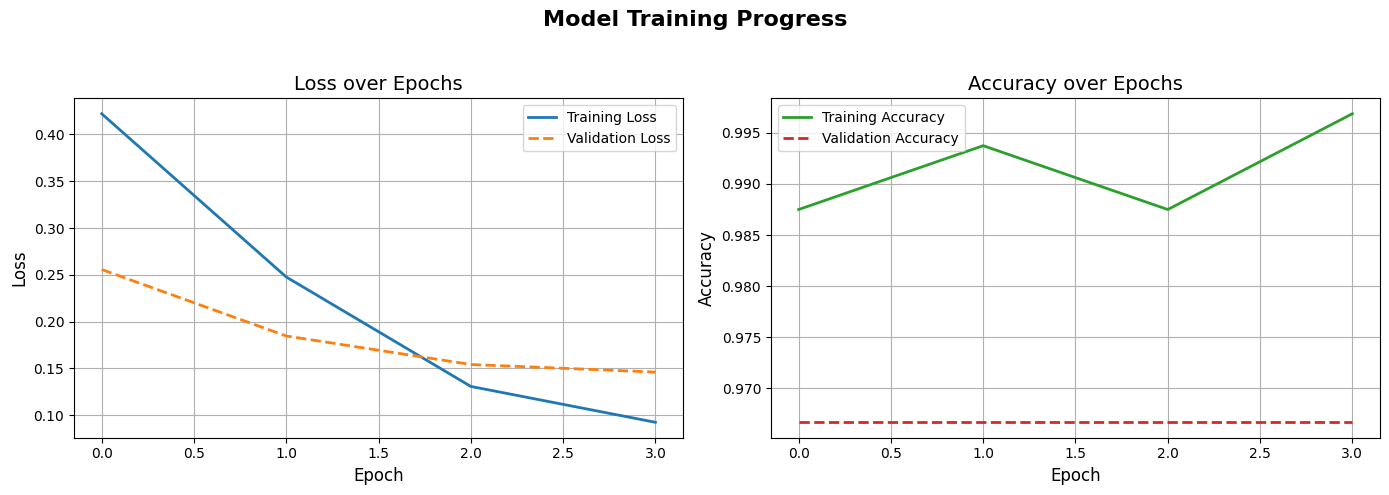

In [29]:
# Plot the model
import matplotlib.pyplot as plt

#plt.style.use("seaborn-v0_8-whitegrid")

fig, axis = plt.subplots(1, 2, figsize=(14, 5))
fig.suptitle("Model Training Progress", fontsize=16, fontweight='bold')

# Loss Plot
axis[0].plot(train_loss, label="Training Loss", color='tab:blue', linewidth=2)
axis[0].plot(val_loss, label="Validation Loss", color='tab:orange', linewidth=2, linestyle='--')
axis[0].set_title("Loss over Epochs", fontsize=14)
axis[0].set_xlabel("Epoch", fontsize=12)
axis[0].set_ylabel("Loss", fontsize=12)
axis[0].legend()
axis[0].grid(True)

# Accuracy Plot
axis[1].plot(train_acc, label="Training Accuracy", color='tab:green', linewidth=2)
axis[1].plot(val_acc, label="Validation Accuracy", color='tab:red', linewidth=2, linestyle='--')
axis[1].set_title("Accuracy over Epochs", fontsize=14)
axis[1].set_xlabel("Epoch", fontsize=12)
axis[1].set_ylabel("Accuracy", fontsize=12)
axis[1].legend()
axis[1].grid(True)

# Improve spacing and layout
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


In [35]:
model.eval()
with torch.no_grad():
    total_loss = 0.0
    total_acc = 0.0
    for img, label in tqdm(test_loader, desc="Procesing Test Loader", total=len(test_loader)):
        img, label = img.to(device), label.to(device)
        prediction = model(img)
        loss = loss_fn(prediction, label)

        total_loss += loss.item()
        pred = torch.argmax(prediction, axis=1)
        acc = (label == pred).float().mean().item()
        total_acc += acc

    print(f"Total ACC: {total_acc / len(test_loader)} | Total Loss: {total_loss / len(test_loader)}")

Procesing Test Loader: 100%|██████████| 3/3 [00:08<00:00,  2.93s/it]

Total ACC: 0.96875 | Total Loss: 0.19755090276400247


In [42]:
import os
import random

def preprocess_single_video(video_path, transform, frame_num=8, device='cuda'):
    video, _, _ = read_video(video_path, pts_unit="sec")  # (T, H, W, C)
    video = video.permute(0, 3, 1, 2)  # (T, C, H, W)
    frames = video[::max(1, len(video) // frame_num)][:frame_num]
    frames = torch.stack([transform(f) for f in frames])  # (T, C, H, W)
    frames = frames.permute(1, 0, 2, 3).unsqueeze(0).to(device)
    return frames


def get_random_video_path(test_root_dir):

    action_dirs = [os.path.join(test_root_dir, d) for d in os.listdir(test_root_dir) if os.path.isdir(os.path.join(test_root_dir, d))]

    # Choose a random action directory
    chosen_action_dir = random.choice(action_dirs)

    videos = [os.path.join(chosen_action_dir, f) for f in os.listdir(chosen_action_dir) if f.endswith(('.avi', '.mp4', '.mov'))]

    chosen_video = random.choice(videos)

    return chosen_video


test_dataset_root = '/content/dataset/UCF101_subset/test'

random_video_path = get_random_video_path(test_dataset_root)
print(f"Randomly selected video path: {random_video_path}")

def annotate_and_save_video(input_video_path, output_video_path, text, text_color=(0,255,0), font_scale=1, thickness=2):
    # Read the video using OpenCV
    cap = cv2.VideoCapture(input_video_path)
    width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    fps = cap.get(cv2.CAP_PROP_FPS)

    # Define the codec and create VideoWriter object
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')  # or 'XVID'
    out = cv2.VideoWriter(output_video_path, fourcc, fps, (width, height))

    font = cv2.FONT_HERSHEY_SIMPLEX
    pos = (10, 30)  # top-left corner

    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break
        # Put text on frame (BGR color)
        cv2.putText(frame, text, pos, font, font_scale, text_color, thickness, cv2.LINE_AA)
        out.write(frame)

    cap.release()
    out.release()
    print(f"Saved annotated video to {output_video_path}")

model.eval()
with torch.no_grad():
    input_tensor = preprocess_single_video(random_video_path, train_transform, frame_num=8, device=device)

    outputs = model(input_tensor)
    predicted_class = torch.argmax(outputs, dim=1).item()

    label_names = train_df["label"].unique().tolist()
    predicted_label = label_names[predicted_class]
    print(f"Predicted activity: {predicted_label}")

    output_path = '/content/annotated_video.mp4'
    annotate_and_save_video(random_video_path, output_path, text=predicted_label)


Randomly selected video path: /content/dataset/UCF101_subset/test/BenchPress/v_BenchPress_g25_c02.avi
Predicted activity: BenchPress
Saved annotated video to /content/annotated_video.mp4
